# Rare Event Binary Classification using Autoencoder

Here we will show an implementation of building a binary classifier using Autoencoders. The purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="darkgrid", context="talk")

import pandas as pd
import numpy as np
from pylab import rcParams
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed; seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

/Users/mess/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mess/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mess/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mess/.local/lib/python3.7/site-packages/tensorboard/compat/tensorf

In [2]:
os.makedirs('assets', exist_ok=True)

## Reading and preparing data

In [3]:
data_file = os.path.join('data', 'processminer-rare-event-mts.csv')

In [4]:
df = pd.read_csv(data_file)

In [5]:
df = df.dropna()

In [6]:
df['y'].value_counts()

0    18274
1      124
Name: y, dtype: int64

In [7]:
'''
Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdyUk3lfDl7I5KYK_pw285LCApc-_RcoC0Tf9cnDnZ_TWzPAw/viewform
'''
# df = pd.read_csv("data/processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [8]:
np.sign(0)

0

In [9]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [10]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before Shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After Shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before Shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After Shifting


,y,time,x1,x2,x3
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954
260,0.0,5/1/99 10:50,0.020062,-3.987897,-1.248529


In [11]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

### Divide the data into train, valid, and test

In [12]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which `y=0` and build an autoencoder. For that, we will divide the datasets as following.

In [13]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

In [14]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

## Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [15]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 59)                1947      
Total params: 5,211
Trainable params: 5,211
Non-trainable params: 0
___________________________________________________________

In [16]:
autoencoder.compile(
    metrics=['accuracy'],
    loss='mean_squared_error',
    optimizer='adam',
)

In [17]:
cp = ModelCheckpoint(
    filepath="autoencoder_classifier.h5",
    save_best_only=True,
    verbose=0,
)

In [18]:
tb = TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=True,
)

In [19]:
history = autoencoder.fit(
    df_train_0_x_rescaled,
    df_train_0_x_rescaled,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
    verbose=0,
    callbacks=[cp, tb],
).history

In [20]:
autoencoder = load_model('autoencoder_classifier.h5')

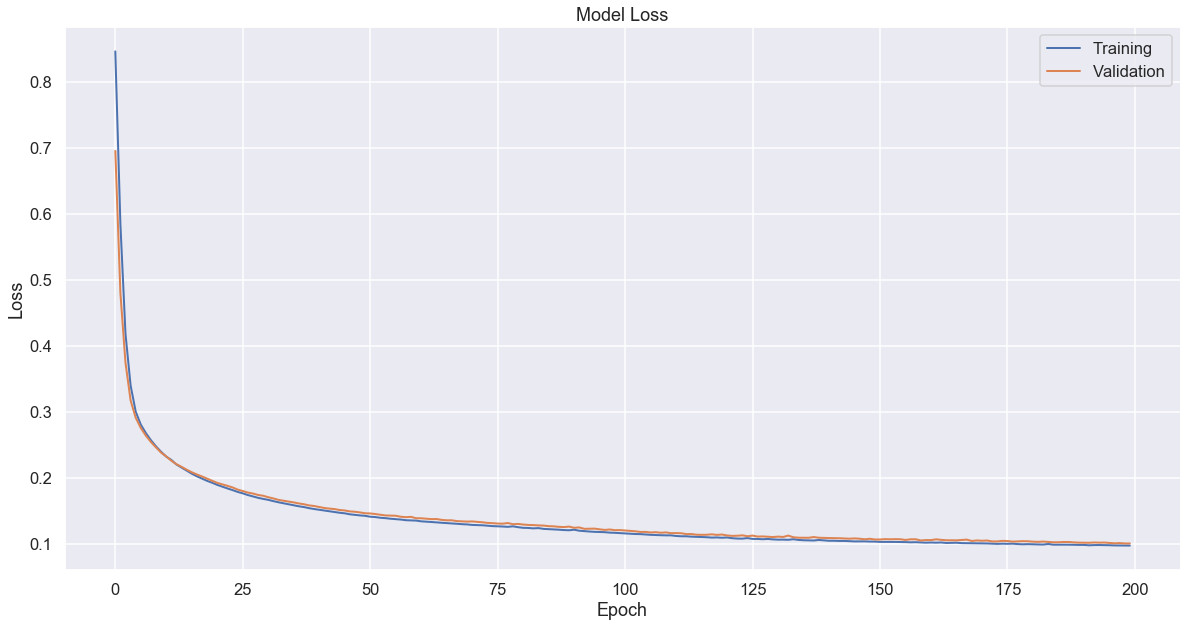

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(history['loss'], linewidth=2, label='Training')
ax.plot(history['val_loss'], linewidth=2, label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

ax.set(
    title="Model Loss",
    xlabel="Epoch",
    ylabel="Loss",
)


ax.legend(loc='upper right')

plt.savefig('assets/loss_curve.png');

In [22]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame(
    {
        'Reconstruction_error': mse,
        'True_class': df_valid['y'],
    },
)

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

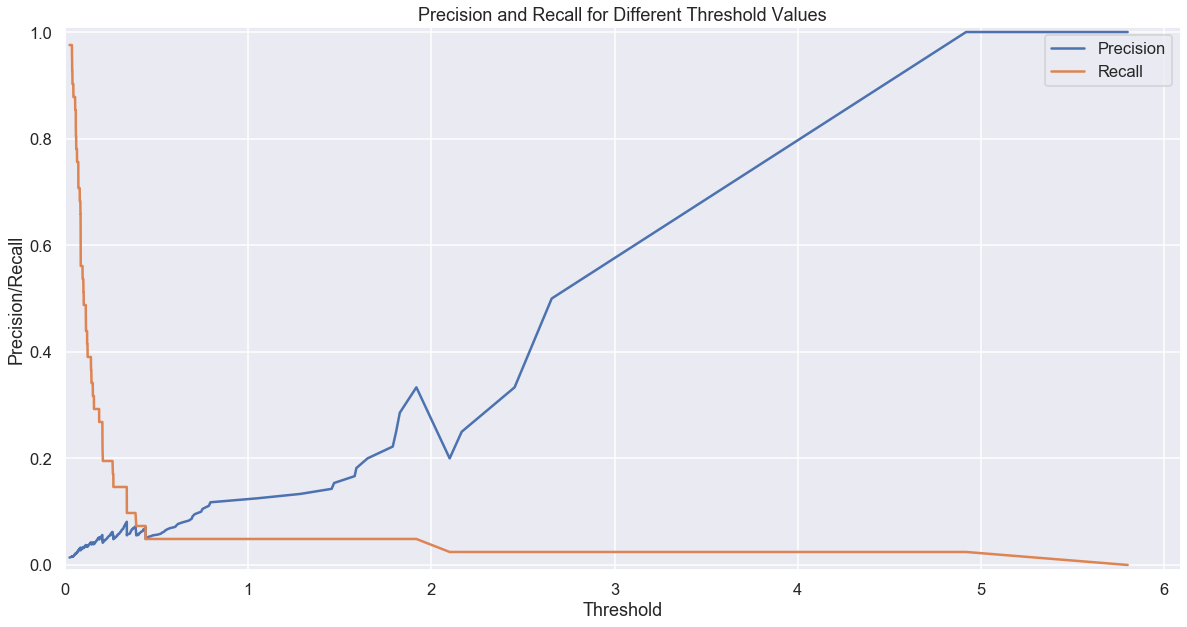

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2.5)
ax.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2.5)

ax.set(
    title="Precision and Recall for Different Threshold Values",
    xlabel="Threshold",
    ylabel="Precision/Recall",
    xlim=(-0.001, ax.get_xlim()[1]),
    ylim=(-0.01, 1.01),
)

ax.legend()

plt.savefig('assets/precision_recall_thresholds.png');

In [24]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

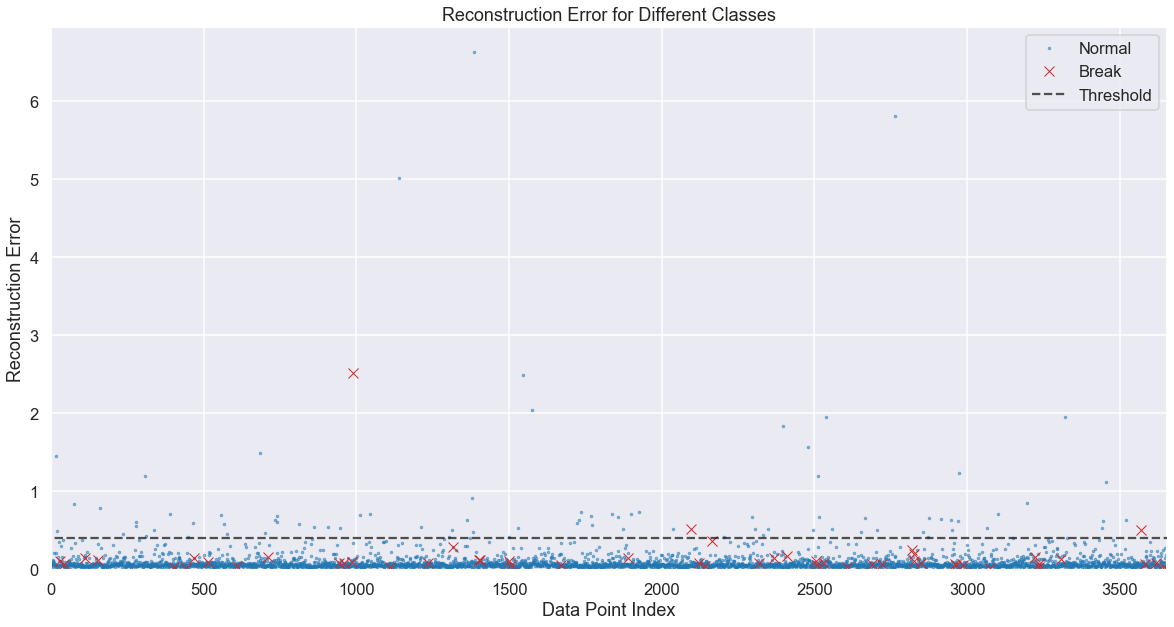

In [25]:
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots(figsize=(20, 10))

idx_min = []
idx_max = []

for name, group in groups:
    ax.plot(
        group.index,
        group.Reconstruction_error,
        marker= "x" if name == 1 else ".",
        ms=10 if name == 1 else 5,
        linestyle='',
        label= "Break" if name == 1 else "Normal",
        alpha= 1. if name == 1 else .5,
        color="tab:red" if name == 1 else "tab:blue"
    )
    idx_min.append(group.index.min())
    idx_max.append(group.index.max())
    
ax.hlines(
    threshold_fixed,
    ax.get_xlim()[0],
    ax.get_xlim()[1],
    colors="k",
    linestyle="--",
    zorder=100,
    label='Threshold',
    alpha=.75,
)

ax.set(
    title="Reconstruction Error for Different Classes",
    xlabel="Data Point Index",
    ylabel="Reconstruction Error",
    xlim=(min(idx_min), max(idx_max)),
    ylim=(-0.01, ax.get_ylim()[1]),
)

ax.legend();


plt.savefig('assets/reconstruction_error.png')

In [26]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [27]:
predictions = pd.DataFrame(
    {
        'true': error_df.True_class,
        'predicted': pred_y,
    },
)

In [28]:
annot_kws = {"ha": 'center', "va": 'center'}

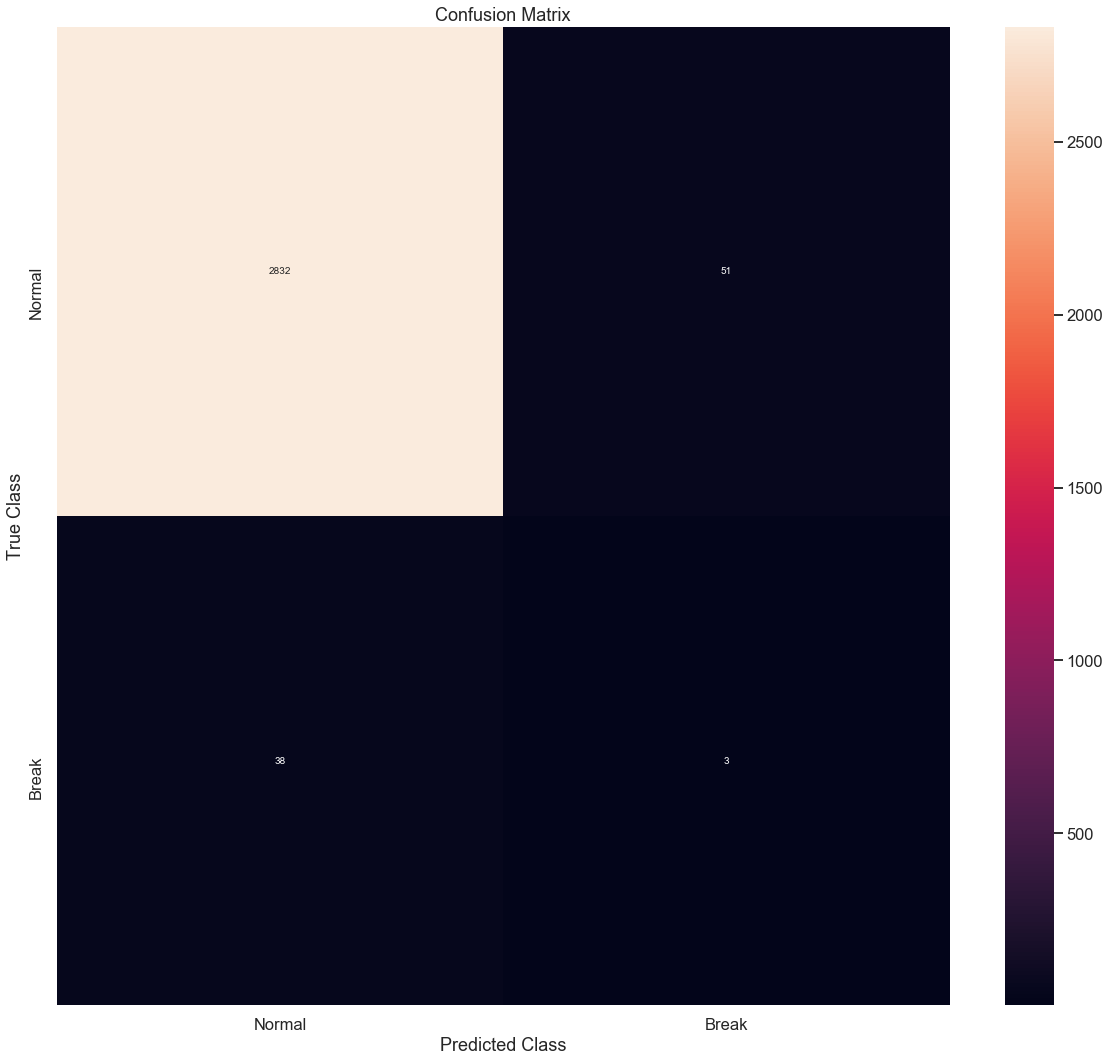

In [29]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

fig, ax = plt.subplots(figsize=(20, 18))

ax = sns.heatmap(conf_matrix, annot=True, fmt=".0f", xticklabels=LABELS, yticklabels=LABELS, ax=ax, annot_kws=annot_kws) 

ax.set(
    title="Confusion Matrix",
    xlabel="Predicted Class",
    ylabel="True Class"
)

plt.savefig('assets/confusion_matrix.png');

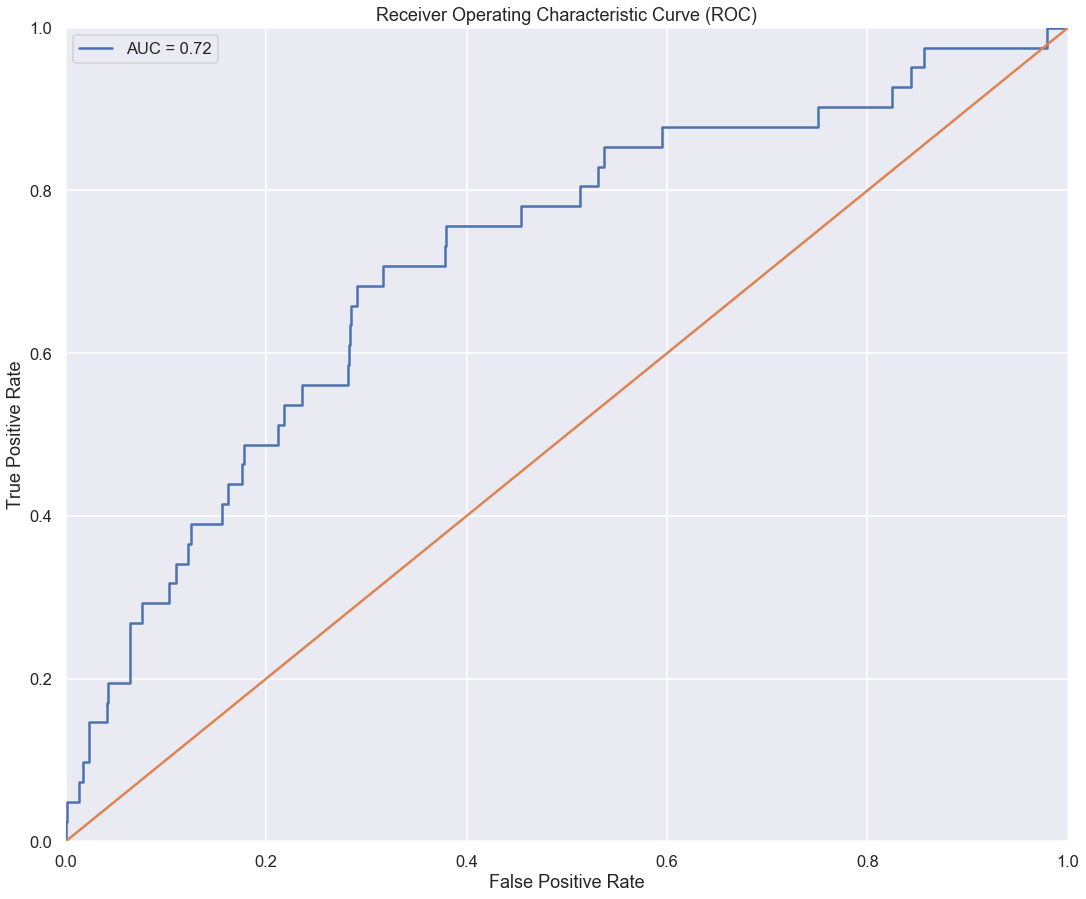

In [30]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

fig, ax = plt.subplots(figsize=(18, 15))

ax.plot(false_pos_rate, true_pos_rate, linewidth=2.5, label=f'AUC = {roc_auc:0.2f}')
ax.plot([0,1],[0,1], linewidth=2.5)


ax.set(
    title='Receiver Operating Characteristic Curve (ROC)',
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=(-0.001, 1.001),
    ylim=(-0.001, 1.001),
)
ax.legend(loc='upper left')

plt.savefig('assets/auc_roc.png');